In [2]:
import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
import torch
import time
import matplotlib.pyplot as plt

In [3]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [4]:
def read_data(file_name, punctual_res=False):
    """
    - Input: crawled data in csv format - Output: sentences
    - punctual_res=False : only reads the text normalization labels
    - punctual_res=True : reads also the punctual restoration labels
    """
    p = re.compile(".*[,].*")
    sentences = []
    with open(file_name, 'r', encoding="utf-8") as f:
        sentence = []
        for line in f:
            parts = line[line.index(',')+1:].split()
            if p.match(parts[0]): 
                if parts[0].split(',')[-1] == 'PERIOD':
                    if len(sentence) > 0: 
                        sentence = [word[0].split(',') for word in sentence]
                        sentences.append(sentence)
                    sentence = []
                elif len(parts[0].split(',')) == 3: 
                    if punctual_res == True: sentence.append(parts)
                    else: 
                        rev_parts = list(reversed(list(parts[0])))
                        index = len(parts[0]) - rev_parts.index(",") - 1
                        sentence.append([parts[0][:index]])
        if len(sentence) > 0: 
            sentence = [word[0].split(',') for word in sentence]
            sentences.append(sentence)
    return sentences

In [5]:
bio = read_data("../input/vnexpress-bio-1/vnexpress_bio_1.csv")

In [6]:
train = bio[len(bio)//5:]
test = bio[:len(bio)//5]

print("Train size: {0} - Test size: {1}".format(len(train), len(test)))

Train size: 101337 - Test size: 25334


In [7]:
print("TRAIN")
for sentence in train[:10]: print(sentence)
print("\nTEST")
for sentence in test[:10]: print(sentence)

TRAIN
[['[SEP]', 'O'], ['trung', 'B-CAP'], ['tướng', 'O'], ['nguyễn', 'B-CAP'], ['quốc', 'I-CAP'], ['thước', 'I-CAP'], ['nguyên', 'O'], ['tư', 'B-CAP'], ['lệnh', 'O'], ['quân', 'B-CAP'], ['khu', 'O'], ['bốn', 'B-NUMB'], ['cũng', 'O'], ['cho', 'O'], ['rằng', 'O'], ['đà', 'B-CAP'], ['nẵng', 'I-CAP'], ['có', 'O'], ['vị', 'O'], ['trí', 'O'], ['đặc', 'O'], ['biệt', 'O'], ['quan', 'O'], ['trọng', 'O'], ['về', 'O'], ['quốc', 'O'], ['phòng', 'O'], ['an', 'O']]
[['người', 'B-CAP'], ['nước', 'O'], ['ngoài', 'O'], ['vào', 'O'], ['làm', 'O'], ['ăn', 'O'], ['chúng', 'O'], ['ta', 'O'], ['hoan', 'O']]
[['nhưng', 'B-CAP'], ['nếu', 'O'], ['họ', 'O'], ['có', 'O'], ['ý', 'O'], ['đồ', 'O'], ['chọn', 'O'], ['vị', 'O'], ['trí', 'O'], ['đất', 'O'], ['có', 'O'], ['yếu', 'O'], ['tố', 'O'], ['quốc', 'O'], ['phòng', 'O'], ['gần', 'O'], ['sân', 'O'], ['bay', 'O'], ['cảng', 'O']]
[['thì', 'O'], ['cần', 'O'], ['hết', 'O'], ['sức', 'O'], ['cảnh', 'O'], ['giác', 'O'], ['tướng', 'O'], ['thước', 'B-CAP']]
[['[SEP]', 'O

In [8]:
batch_size = 64
max_seq_len = 128
word_len = 300

In [9]:
vocab_size = 1024*6
print("vocab_size:", vocab_size)
vocab = {}
for sentence in train + test:
    for w, l1 in sentence: 
        vocab[w] = vocab.get(w,0)+1

vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
vocab = [word for word, count in vocab[:vocab_size - 2]] + ["[UNK]", "[PAD]"]
print(vocab)

vocab_size: 6144
['hai', '[SEP]', 'không', 'một', 'trăm', 'mươi', 'năm', 'ba', 'và', 'mười', 'bốn', 'tháng', 'chín', 'có', 'các', 'nghìn', 'người', 'sáu', 'được', 'cho', 'bảy', 'của', 'công', 'trong', 'tám', 'đến', 'thành', 'ông', 'với', 'là', 'đã', 'ngàn', 'để', 'dân', 'từ', 'ngày', 'bộ', 'ở', 'nhân', 'về', 'phố', 'học', 'tư', 'trung', 'nhà', 'tại', 'thông', 'nước', 'hiện', 'trên', 'quốc', 'việc', 'khi', 'theo', 'định', 'lăm', 'ban', 'bị', 'trường', 'đồng', 'đầu', 'làm', 'ra', 'nhăm', 'nam', 'đó', 'nhiều', 'vào', 'xe', 'số', 'này', 'đường', 'chính', 'động', 'chủ', 'sẽ', 'dự', 'phải', 'bệnh', 'chỉ', 'cơ', 'quan', 'những', 'chức', 'phòng', 'xã', 'cách', 'hà', 'sau', 'hơn', 'an', 'lý', 'đi', 'tỉnh', 'cũng', 'gia', 'giao', 'án', 'văn', 'hội', 'sinh', 'việt', 'hợp', 'nội', 'khu', 'phương', 'vụ', 'tế', 'lại', 'hàng', 'hành', 'sở', 'thể', 'qua', 'hồ', 'trước', 'viên', 'nguyễn', 'cấp', 'mốt', 'cao', 'phát', 'quy', 'biết', 'tiếp', 'điều', 'nhận', 'cầu', 'đề', 'thời', 'đại', 'minh', 'còn', 'huy

In [10]:
def create_dataset(data):
    """Padding '[PAD]' to reach max_seq_len and convert words out of vocab_size to '[UNK]'"""
    pad_index = vocab.index("[PAD]")
    sentences = []
    for _sentence in tqdm(data):
        sentence = []
        for word, label1 in _sentence:
            word = word.lower()
            if word not in vocab:
                word = "[UNK]"
            index = vocab.index(word)
            sentence.append((index, label1))
        while len(sentence) < max_seq_len:
            sentence.append((pad_index, "O"))
        sentence = sentence[:max_seq_len]
        sentences.append(sentence)
    return sentences

trainset = create_dataset(train)
testset = create_dataset(test)

In [11]:
del train
del test
del bio 

In [12]:
for sentence in trainset[:10]:
    print(sentence)

[(6142, 'O'), (43, 'B-CAP'), (313, 'O'), (117, 'B-CAP'), (50, 'I-CAP'), (1656, 'I-CAP'), (206, 'O'), (42, 'B-CAP'), (844, 'O'), (294, 'B-CAP'), (104, 'O'), (10, 'B-NUMB'), (94, 'O'), (19, 'O'), (362, 'O'), (253, 'B-CAP'), (322, 'I-CAP'), (13, 'O'), (201, 'O'), (358, 'O'), (503, 'O'), (571, 'O'), (81, 'O'), (346, 'O'), (39, 'O'), (50, 'O'), (84, 'O'), (90, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'), (6143, 'O'),

In [13]:
# traditional model

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = torch.nn.Embedding(vocab_size, word_len)
        self.lstm = torch.nn.LSTM(word_len, 512//2, bidirectional=True)
        self.decoder = torch.nn.Linear(512, 7)

    def forward(self, input_ids, label_ids=None):
        X = self.encoder(input_ids)   # [16, 128, 10]
        X, _ = self.lstm(X)           # [16, 128, 512]
        X = self.decoder(X)           # [16, 128, 3]

        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='mean')

        if label_ids is not None:
            X = X.reshape(batch_size*128, 7)
            label_ids = label_ids.reshape(batch_size*128,)
            #print("input:", X.shape)               # [2048, 3]
            #print("target:", label_ids.shape)      # [2048]
            # ...... argmax(X) -> compare to label_ids -> acc
            loss = loss_fct(X, label_ids)
            return loss
        else:
            return torch.argmax(X, -1)

model = Model()
print(model)

Model(
  (encoder): Embedding(6144, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (decoder): Linear(in_features=512, out_features=7, bias=True)
)


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [15]:
accs = []
losses = []
n_epoch = 5
for epoch in range(1, n_epoch+1):
    start = 0
    for batch_step in tqdm(range(batch_size, len(trainset), batch_size), leave=False):
        model.zero_grad()
        batch = trainset[start:batch_step]
        start = batch_step
        if len(batch) == batch_size:
            input_ids = []
            label1_ids = []
            # label2_ids = []
            for sentence in batch:
                input_id = []
                label1_id = []
                # label2_id = []
                for word, label1 in sentence:
                    input_id.append(word)
                    if word == 6143 and label1 == 'O': label1_id.append(-100)
                    else: 
                        label1_id.append(["B-CAP", "I-CAP", "B-NUMB", "I-NUMB", "B-DATE", "I-DATE", "O"].index(label1))
                    # label2_id.append(["PERIOD", "COMMA", "EXCLAIMATIONMARK", "QUESTIONMARK", "SEMICOLON", "COLON", "DASH", "O"].index(label2))
                input_ids.append(input_id)
                label1_ids.append(label1_id)
                # label2_ids.append(label2_id)
            input_ids = torch.LongTensor(input_ids)
            label1_ids = torch.LongTensor(label1_ids)
            # label2_ids = torch.LongTensor(label2_ids)
            
            model.eval()
            output = model(input_ids)
            loss = model(input_ids, label1_ids)
            step = start//batch_size
            acc = sum(pd.Series(label1_ids[0]) == pd.Series(output[0]))/sum(pd.Series(label1_ids[0])!=-100)*100
            accs.append([epoch, acc])
            losses.append([epoch, loss.item()])
            
            loss.backward()
            optimizer.step()
        else: continue
    print(f"Epoch {epoch}: Done")

Epoch 1: Done


Epoch 2: Done


Epoch 3: Done


Epoch 4: Done


Epoch 5: Done


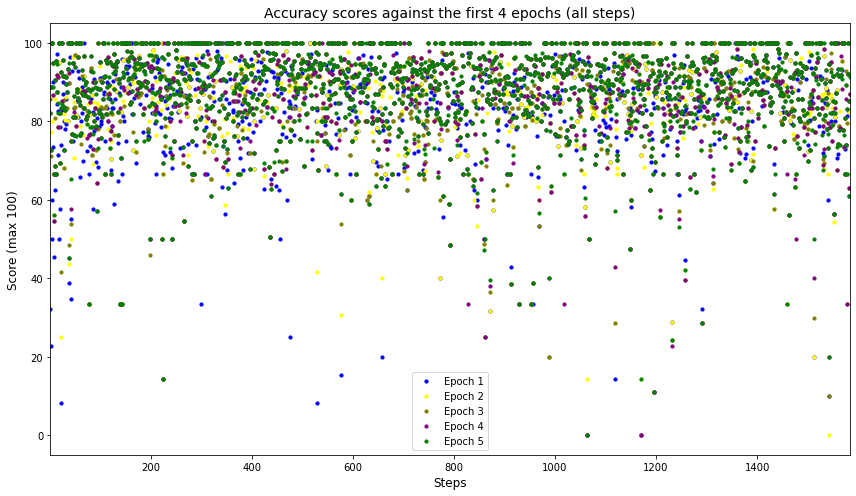

In [25]:
# Plotting
acc_e1 = [acc[1] for acc in accs if acc[0] == 1]
acc_e2 = [acc[1] for acc in accs if acc[0] == 2]
acc_e3 = [acc[1] for acc in accs if acc[0] == 3]
acc_e4 = [acc[1] for acc in accs if acc[0] == 4]
acc_e5 = [acc[1] for acc in accs if acc[0] == 5]

steps = range(1, len(accs)//5 + 1)

fig, axes = plt.subplots(1,1, figsize=(12,7))
axes.margins(0.05)
axes.scatter(steps, acc_e1, color='blue', s=10, label='Epoch 1')
axes.scatter(steps, acc_e2, color='yellow', s=10, label='Epoch 2')
axes.scatter(steps, acc_e3, color='olive', s=10, label='Epoch 3')
axes.scatter(steps, acc_e4, color='purple', s=10, label='Epoch 4')
axes.scatter(steps, acc_e5, color='green', s=10, label='Epoch 5')

axes.set_title("Accuracy scores against the first 4 epochs (all steps)", size=14)
axes.set_xlabel("Steps", size=12)
axes.set_ylabel("Score (max 100)", size=12)
axes.legend()

fig.tight_layout()
plt.margins(x=0)
plt.show()

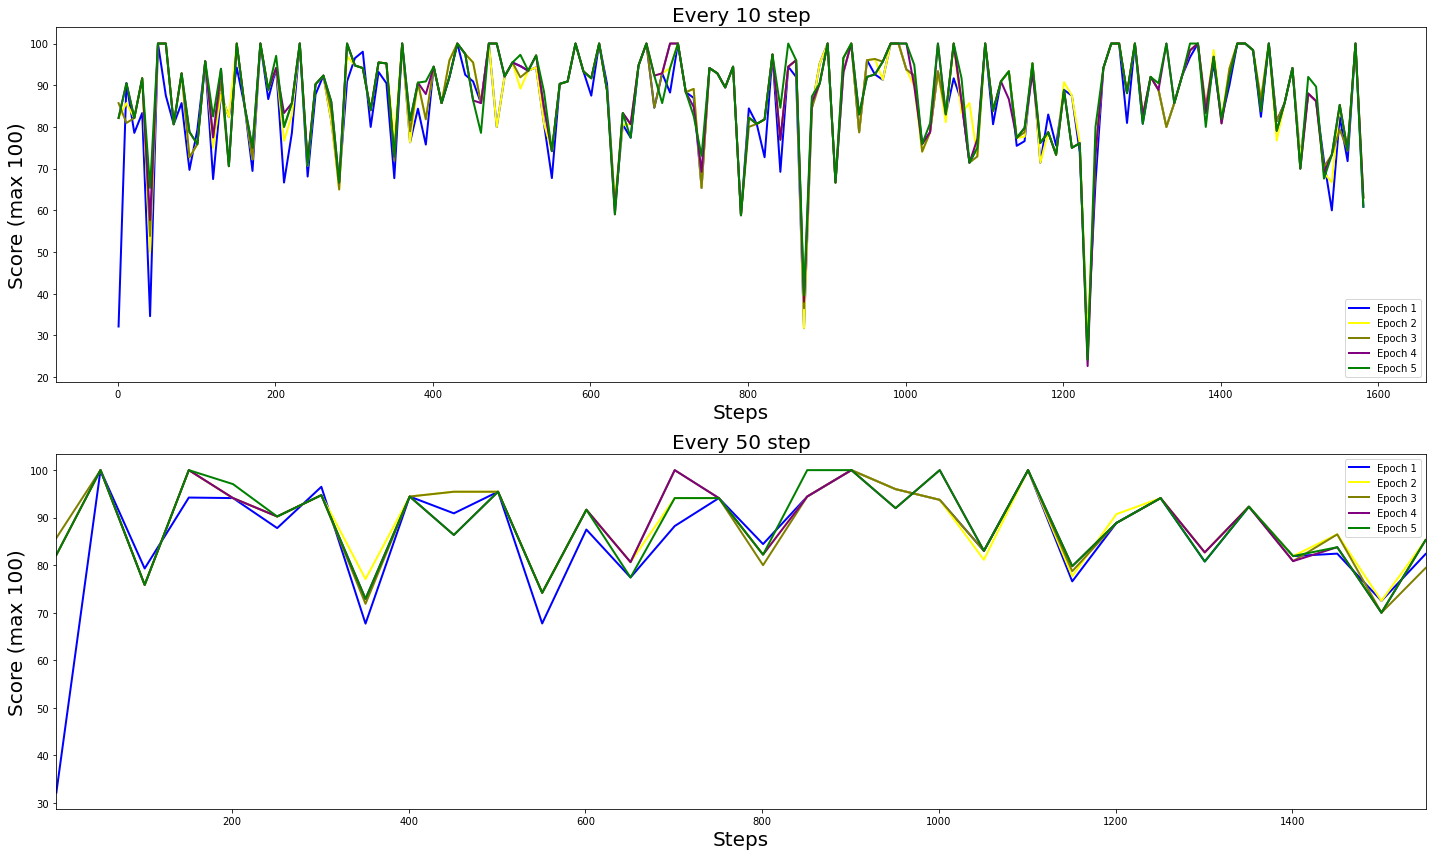

In [28]:
fig = plt.figure(figsize=(20,12))

# 10 step
ax1 = fig.add_subplot(2,1,1)
ax1.margins(0.05)
ax1.plot(steps[::10], acc_e1[::10], color='blue', linewidth=2, label='Epoch 1')
ax1.plot(steps[::10], acc_e2[::10], color='yellow', linewidth=2, label='Epoch 2')
ax1.plot(steps[::10], acc_e3[::10], color='olive', linewidth=2, label='Epoch 3')
ax1.plot(steps[::10], acc_e4[::10], color='purple', linewidth=2, label='Epoch 4')
ax1.plot(steps[::10], acc_e5[::10], color='green', linewidth=2, label='Epoch 5')

ax1.set_title("Every 10 step", size=20)
ax1.set_xlabel("Steps", size=20)
ax1.set_ylabel("Score (max 100)", size=20)
ax1.legend()

# 50 step
ax2 = fig.add_subplot(2,1,2)
ax2.margins(0.05)
ax2.plot(steps[::50], acc_e1[::50], color='blue', linewidth=2, label='Epoch 1')
ax2.plot(steps[::50], acc_e2[::50], color='yellow', linewidth=2, label='Epoch 2')
ax2.plot(steps[::50], acc_e3[::50], color='olive', linewidth=2, label='Epoch 3')
ax2.plot(steps[::50], acc_e4[::50], color='purple', linewidth=2, label='Epoch 4')
ax2.plot(steps[::50], acc_e5[::50], color='green', linewidth=2, label='Epoch 5')

ax2.set_title("Every 50 step", size=20)
ax2.set_xlabel("Steps", size=20)
ax2.set_ylabel("Score (max 100)", size=20)
ax2.legend()

fig.tight_layout()
plt.margins(x=0)
plt.show()

In [ ]:
test_input_ids = []
test_label1_ids = []
for sentence in testset[:]:
    test_input_id = []
    test_label1_id = []
    for word, label1 in sentence:
        test_input_id.append(word)
        test_label1_id.append(["B-CAP", "I-CAP", "B-NUMB", "I-NUMB", "B-DATE", "I-DATE", "O"].index(label1))
        
    test_input_ids.append(test_input_id)
    test_label1_ids.append(test_label1_id)
    
test_input_ids = torch.LongTensor(test_input_ids)
test_label1_ids = torch.LongTensor(test_label1_ids)